## Pretrain single model

In [3]:
%load_ext autoreload
%autoreload 2


import sys; sys.path.append(2*'../')

import torch
import torch.nn as nn
from pathlib import Path
import wandb
from torchdyn.numerics import odeint
from tqdm.auto import tqdm

from math import pi as π

from kse527.systems.rendering.cartpole import CartPoleRendering
from kse527.control.cost import IntegralCost
from kse527.models.activations.snake import Snake
from kse527.tasks.default import DynamicSystemLearner
from notebooks.mpc.mpc import TorchMPC
from notebooks.mpc.utils_mpc import CartPole, CartpoleIntegralCost, BoxConstrainedController, RandConstController
from notebooks.mpc.utils import NeuralModelWrapper


In [5]:
# Load model
from pathlib import Path
path = Path('saved_models/')

_model = torch.load(path / 'model_example.pt')
model_nn = NeuralModelWrapper(_model, RandConstController())

## MPC

In [8]:
# Change device according to your configuration
# device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device=torch.device('cpu')

# Loss function declaration
x_star = torch.Tensor([0. , 0.,  0., 0.]).to(device)
cost_func = CartpoleIntegralCost(x_star)

# Time span
dt = 0.02 # NOTE: should be the same as before
t0, tf = 0, 2 # initial and final time for controlling the system
steps = int((tf - t0)/dt) + 1 # so we have a time step of 0.2s
t_span = torch.linspace(t0, tf, steps).to(device)

# Initial condition
bs = 1
x0 = torch.Tensor([1, 0, π, 0]).repeat(bs, 1)

# Real system
const_u = RandConstController([1, 1], -1, 1).to(device) # dummy constant controller for simulation
real_system = CartPole(u=const_u, solver='rk4')

# MPC variables
eps_accept = 1e-1
lookahead_steps = int(1/dt) # 2 seconds ahead # BETTER only 1 second!
bs = 1 # we use batched training so to see more initial conditions
steps_nom = 5 # Nominal steps to do between each MPC step
max_iters = 30 # NOTE: the number of iterations seems to affect greatly the results, especially for higher order solvers
lr = 3e-3 # adjust learning rate for avoiding "underflow in dt nan" from torchdiffeq
weight_decay = 1e-4 # L2 regularization seems to have a major impact in training MPC!

# Controller
# Make sure boundaries are INSIDE the training region!
u = BoxConstrainedController(4, 1, num_layers=2, constrained=True, output_scaling=torch.Tensor([-30, 30])).to(device)
opt = torch.optim.Adam(u.parameters(), lr=lr, weight_decay=weight_decay) # optimizer
model_nn.u = u

In [9]:
# Run MPC

mpc = TorchMPC(model_nn, cost_func, t_span, opt, eps_accept=eps_accept, max_g_iters=max_iters,
            lookahead_steps=lookahead_steps, lower_bounds=None,
            upper_bounds=None, penalties=None).to(device)

loss_mpc = mpc.forward_simulation(real_system, x0, t_span, reset=False)

Starting simulation... Timestamp: 0.0000
Inner-loop did not converge, last cost: 36.426 | Timestamp: 0.0200 s
Inner-loop did not converge, last cost: 20.522 | Timestamp: 0.0400 s
Inner-loop did not converge, last cost: 18.353 | Timestamp: 0.0600 s
Inner-loop did not converge, last cost: 20.190 | Timestamp: 0.0800 s
Inner-loop did not converge, last cost: 15.654 | Timestamp: 0.1000 s
Inner-loop did not converge, last cost: 20.055 | Timestamp: 0.1200 s
Inner-loop did not converge, last cost: 14.487 | Timestamp: 0.1400 s
Inner-loop did not converge, last cost: 11.136 | Timestamp: 0.1600 s
Inner-loop did not converge, last cost: 9.648 | Timestamp: 0.1800 s
Inner-loop did not converge, last cost: 8.656 | Timestamp: 0.2000 s
Inner-loop did not converge, last cost: 7.981 | Timestamp: 0.2200 s
Inner-loop did not converge, last cost: 6.938 | Timestamp: 0.2400 s
Inner-loop did not converge, last cost: 6.202 | Timestamp: 0.2600 s
Inner-loop did not converge, last cost: 5.534 | Timestamp: 0.2800 s

## Plotting and rendering

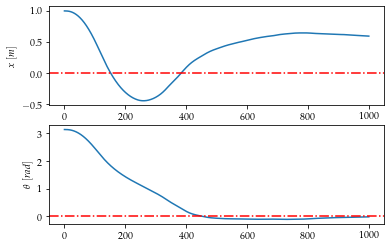

In [10]:
import matplotlib.pyplot as plt

# Style
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "figure.facecolor": "white"
})

fig, axs = plt.subplots(2,1)

xlabel = 'Time [$s$]'
trajs = [mpc.trajectory_nominal[:,0,0], mpc.trajectory_nominal[:,0,2]]
ylabels = [r'$x~[m]$', r'$\theta~[rad]$']


for ax, traj, ylabel in zip(axs, trajs, ylabels):
    ax.plot(traj)
    ax.set_ylabel(ylabel)
    ax.axhline(0, color='red', linestyle='-.')

In [13]:
time_idx = 20
x_render = mpc.trajectory_nominal[time_idx].squeeze()

# Rendering
rendering_env = CartPoleRendering()
rendering_env.render(x_render)

In [ ]:
# Close renderer
rendering_env.close()